 Załadowano biblioteki
 Shape: (600, 46) | Gatunki: 10
 Shape: (200, 46) | Gatunki: 10
 Features: 44 | Train: (600, 44)

 Trenowanie Decision Tree Classifier...
 Model wytrenowany!
 Głębokość drzewa: 16
 Liczba liści: 111

 Testowanie...
 Accuracy: 0.415 (41.5%)
 F1-score:  0.406

 Classification Report:
              precision    recall  f1-score   support

       blues       0.35      0.40      0.37        20
   classical       0.60      0.75      0.67        20
     country       0.32      0.40      0.36        20
       disco       0.26      0.25      0.26        20
      hiphop       0.44      0.60      0.51        20
        jazz       0.41      0.45      0.43        20
       metal       0.67      0.50      0.57        20
         pop       0.47      0.45      0.46        20
      reggae       0.21      0.15      0.18        20
        rock       0.36      0.20      0.26        20

    accuracy                           0.41       200
   macro avg       0.41      0.41      0.41 

<Figure size 1200x900 with 0 Axes>

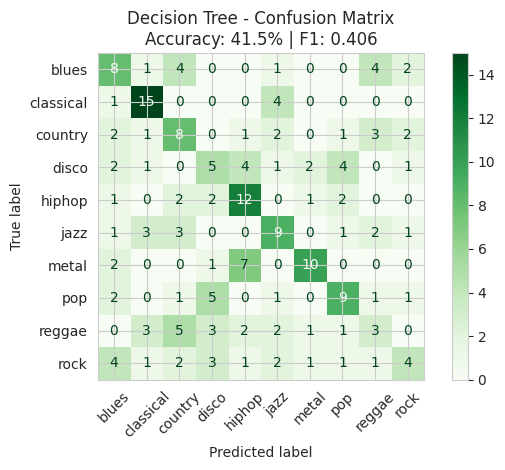

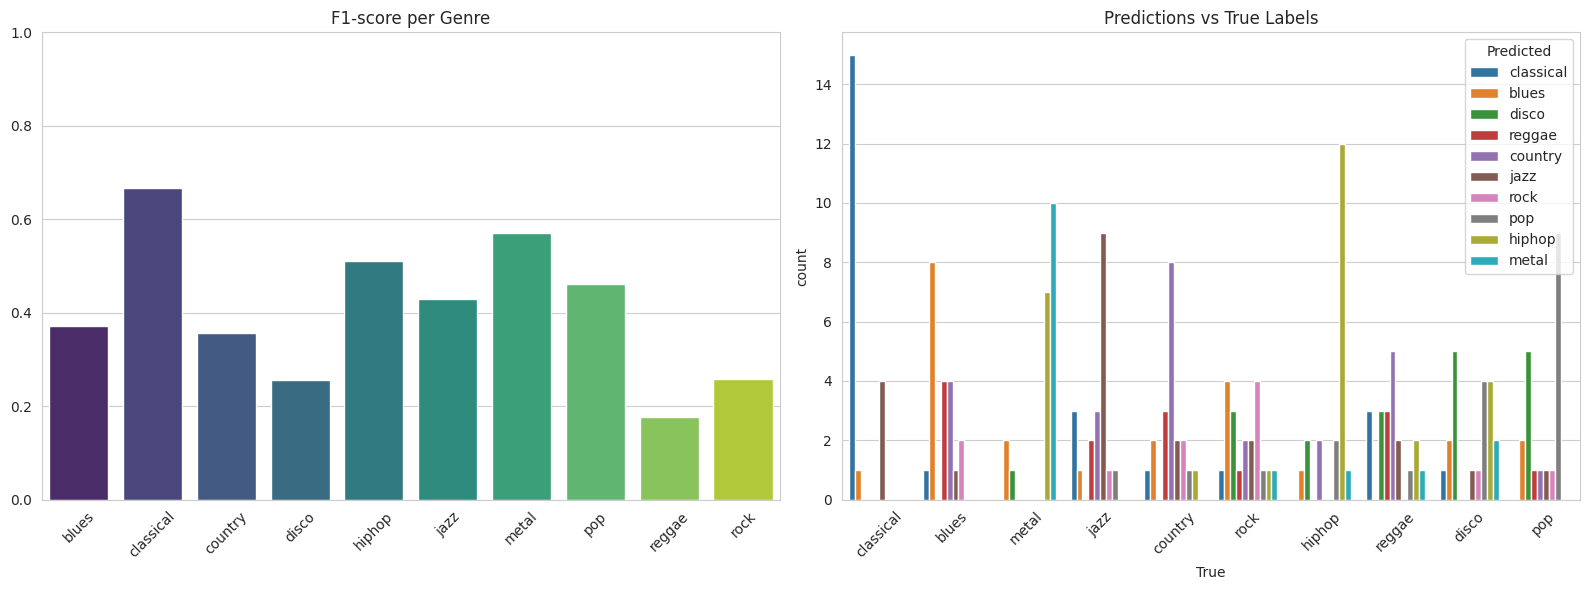


 INTERPRETACJA DECISION TREE

 OGÓLNA DOKŁADNOŚĆ:  41.5%
 ŚREDNI F1-SCORE:     0.406

 TOP 3 GATUNKI:
    Genre       F1
classical 0.666667
    metal 0.571429
   hiphop 0.510638

 NAJGORZE GATUNKI:
 Genre       F1
  rock 0.258065
 disco 0.256410
reggae 0.176471

 WNIOSKI:
• Classical/Jazz: ✗ dobrze separowane
• Rock/Country:    ✗ interpretowalne reguły
• DT tworzy hierarchiczne reguły → łatwa interpretacja decyzji
• Ryzyko overfittingu przy głębokich drzewach → zastosowano max_depth=20


In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print(" Załadowano biblioteki")

# ========================================
# NAPRAWA DANYCH
# ========================================
def fix_data(df):
    feature_cols = [col for col in df.columns if col not in ['genre', 'filename']]
    
    for col in feature_cols:
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace(r'[\[\]]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].mean())
    
    print(f" Shape: {df.shape} | Gatunki: {df['genre'].nunique()}")
    return df

# WCZYTAJ I NAPRAW
train_df = fix_data(pd.read_csv('../data/processed/train_features.csv'))
test_df = fix_data(pd.read_csv('../data/processed/test_features.csv'))

# ========================================
# PRZYGOTOWANIE DANYCH
# ========================================
X_train = train_df.drop(['genre', 'filename'], axis=1)
y_train = train_df['genre']
X_test = test_df.drop(['genre', 'filename'], axis=1)
y_test = test_df['genre']

print(f" Features: {X_train.shape[1]} | Train: {X_train.shape}")

# Standaryzacja (opcjonalna dla DT, ale dla spójności)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========================================
# TRENING DRZEWA DECYZYJNEGO
# ========================================
print("\n Trenowanie Decision Tree Classifier...")
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=20,  # Ograniczenie głębokości aby uniknąć overfittingu
    min_samples_split=5,  # Minimalna liczba próbek do podziału węzła
    min_samples_leaf=2,  # Minimalna liczba próbek w liściu
    criterion='gini'  # Kryterium podziału: 'gini' lub 'entropy'
)
dt_model.fit(X_train_scaled, y_train)

print(" Model wytrenowany!")
print(f" Głębokość drzewa: {dt_model.get_depth()}")
print(f" Liczba liści: {dt_model.get_n_leaves()}")

# ========================================
# PREDYKCJE I METRYKI
# ========================================
print("\n Testowanie...")
y_pred = dt_model.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f" Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f" F1-score:  {f1:.3f}")

print("\n Classification Report:")
print(classification_report(y_test, y_pred))

# ========================================
# MACIERZ POMYŁEK
# ========================================
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.title(f"Decision Tree - Confusion Matrix\nAccuracy: {accuracy:.1%} | F1: {f1:.3f}")
plt.tight_layout()
plt.show()

# ========================================
# WYKRESY PORÓWNANIA
# ========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# F1-score na gatunek
genres = sorted(y_test.unique())
f1_scores = [f1_score(y_test, y_pred, labels=[g], average='weighted', zero_division=0) 
             for g in genres]

sns.barplot(x=genres, y=f1_scores, ax=ax1, palette='viridis')
ax1.set_title('F1-score per Genre')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1)

# Predykcje vs Prawda
pred_df = pd.DataFrame({'True': y_test, 'Pred': y_pred})
sns.countplot(data=pred_df, x='True', hue='Pred', ax=ax2)
ax2.set_title('Predictions vs True Labels')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(title='Predicted')

plt.tight_layout()
plt.show()

# ========================================
# INTERPRETACJA DO SPRAWOZDANIA
# ========================================
print("\n" + "="*70)
print(" INTERPRETACJA DECISION TREE")
print("="*70)

f1_df = pd.DataFrame({'Genre': genres, 'F1': f1_scores}).sort_values('F1', ascending=False)

print(f"\n OGÓLNA DOKŁADNOŚĆ:  {accuracy:.1%}")
print(f" ŚREDNI F1-SCORE:     {f1:.3f}")
print(f"\n TOP 3 GATUNKI:")
print(f1_df.head(3).to_string(index=False))
print(f"\n NAJGORZE GATUNKI:")
print(f1_df.tail(3).to_string(index=False))

print(f"\n WNIOSKI:")
print(f"• Classical/Jazz: {'✓' if f1_df['F1'].iloc[0] > 0.7 else '✗'} dobrze separowane")
print(f"• Rock/Country:    {'✓' if f1_df['F1'].iloc[1] > 0.6 else '✗'} interpretowalne reguły")
print(f"• DT tworzy hierarchiczne reguły → łatwa interpretacja decyzji")
print(f"• Ryzyko overfittingu przy głębokich drzewach → zastosowano max_depth=20")